# Predictive Analytics - Microsoft Daily Stock Data (Forecasting)

Dalam proyek ini, model predictive akan dibangun untuk membantu memprediksi harga saham Microsoft dengan target fitur Close karena dianggap paling mempresentasikan harga saham pada hari tersebut.

## 1. Import Libraries

Pada tahapan ini akan di import semua library yang digunakan dalam project predictive analysis ini.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

import plotly.graph_objects as go

import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

## 2. Data Loading

Pada tahapan ini, dataset microsft daily stock dimuat untuk selanjutnya akan dilakukan analisa.

In [2]:
df = pd.read_csv('MSFT_daily_stock_data.csv')

In [3]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.059946,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062087,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063158,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061552,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060482,47894400
...,...,...,...,...,...,...,...
9732,2024-10-24,425.329987,425.980011,422.399994,424.730011,424.730011,13581600
9733,2024-10-25,426.760010,432.519989,426.570007,428.149994,428.149994,16899100
9734,2024-10-28,431.660004,431.940002,426.299988,426.589996,426.589996,14882400
9735,2024-10-29,428.000000,433.170013,425.799988,431.950012,431.950012,17644100


## 3. Exploratory Data Analysis

Pada tahapan ini kita akan menganalisa dataset yang kita gunakan dan melakukan eksplorasi lebih lanjut sebelum dilakukan proses pembangunan model awal.

### 3.1 Deskripsi Variabel

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9737 entries, 0 to 9736
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9737 non-null   object 
 1   Open       9737 non-null   float64
 2   High       9737 non-null   float64
 3   Low        9737 non-null   float64
 4   Close      9737 non-null   float64
 5   Adj Close  9737 non-null   float64
 6   Volume     9737 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 532.6+ KB


In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,9737.000000,9737.000000,9737.000000,9737.000000,9737.000000,9.737000e+03
mean,60.813783,61.430055,60.172971,60.823922,55.162815,5.652701e+07
std,94.519709,95.369718,93.588185,94.522300,94.588374,3.814013e+07
min,0.088542,0.092014,0.088542,0.090278,0.055665,2.304000e+06
25%,5.789063,5.867188,5.695313,5.789063,3.569499,3.169170e+07
50%,27.360001,27.709999,27.150000,27.400000,19.218304,4.968890e+07
75%,47.099998,47.599998,46.529999,47.110001,39.407841,7.043040e+07
max,467.000000,468.350006,464.459991,467.559998,466.718781,1.031789e+09


Hasil analisa awal menunjukan dataset 7 fitur yang berisi 1 feature object dan 6 feature numerikal

### 3.2 Menangani Missing Values

In [6]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Hasil pengecekan missing values terlihat semua baris atau sampel data tidak memiliki nilai yang hilang, sehingga tidak perlu dilakukan pembersihan

### 3.3 Menangani Outliers

Pada tahapan ini kita akan memeriksa outliers dari dataset yang digunakan

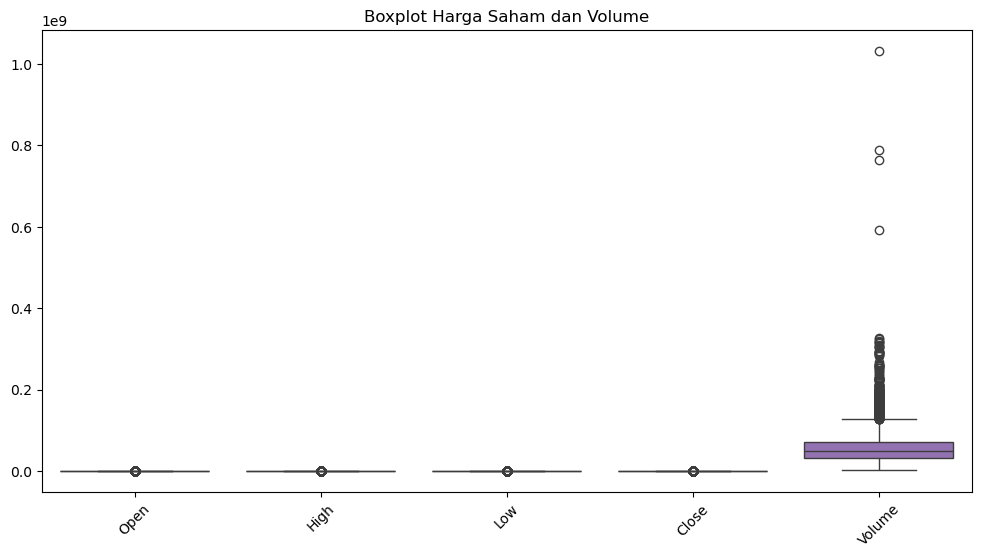

In [7]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['Open', 'High', 'Low', 'Close', 'Volume']])
plt.title('Boxplot Harga Saham dan Volume')
plt.xticks(rotation=45)
plt.show()

In [8]:
z_scores = np.abs(stats.zscore(df[['Open', 'High', 'Low', 'Close', 'Volume']]))
threshold = 3
outlier_z = (z_scores > threshold)

outlier_count_z = outlier_z.sum(axis=0)
print("Jumlah outlier menggunakan Z-Score:\n", outlier_count_z)

Jumlah outlier menggunakan Z-Score:
 Open      261
High      259
Low       259
Close     259
Volume    131
dtype: int64


In [9]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((data[column] < lower_bound) | (data[column] > upper_bound)).sum()

outlier_count_iqr = {col: detect_outliers_iqr(df, col) for col in ['Open', 'High', 'Low', 'Close', 'Volume']}
print("Jumlah outlier menggunakan IQR:\n", outlier_count_iqr)

Jumlah outlier menggunakan IQR:
 {'Open': 1482, 'High': 1480, 'Low': 1484, 'Close': 1480, 'Volume': 369}


Berdasarkan pemeriksaan, tampak outlier yang muncul adalah outlier yang bisa dianggap wajar dikarenakan adanya fluktuasi harga saham pada saat-saat tertentu.

### 3.4 Univariate Analysis

Pada tahapan ini tipe data untuk fitur `Date` akan diubah dulu menjadi `datetime` agar lebih sesuai

In [10]:
df['Date'] = pd.to_datetime(df['Date'])

Pada tahapan ini distribusi dari setiap fitur numerik akan dilihat.

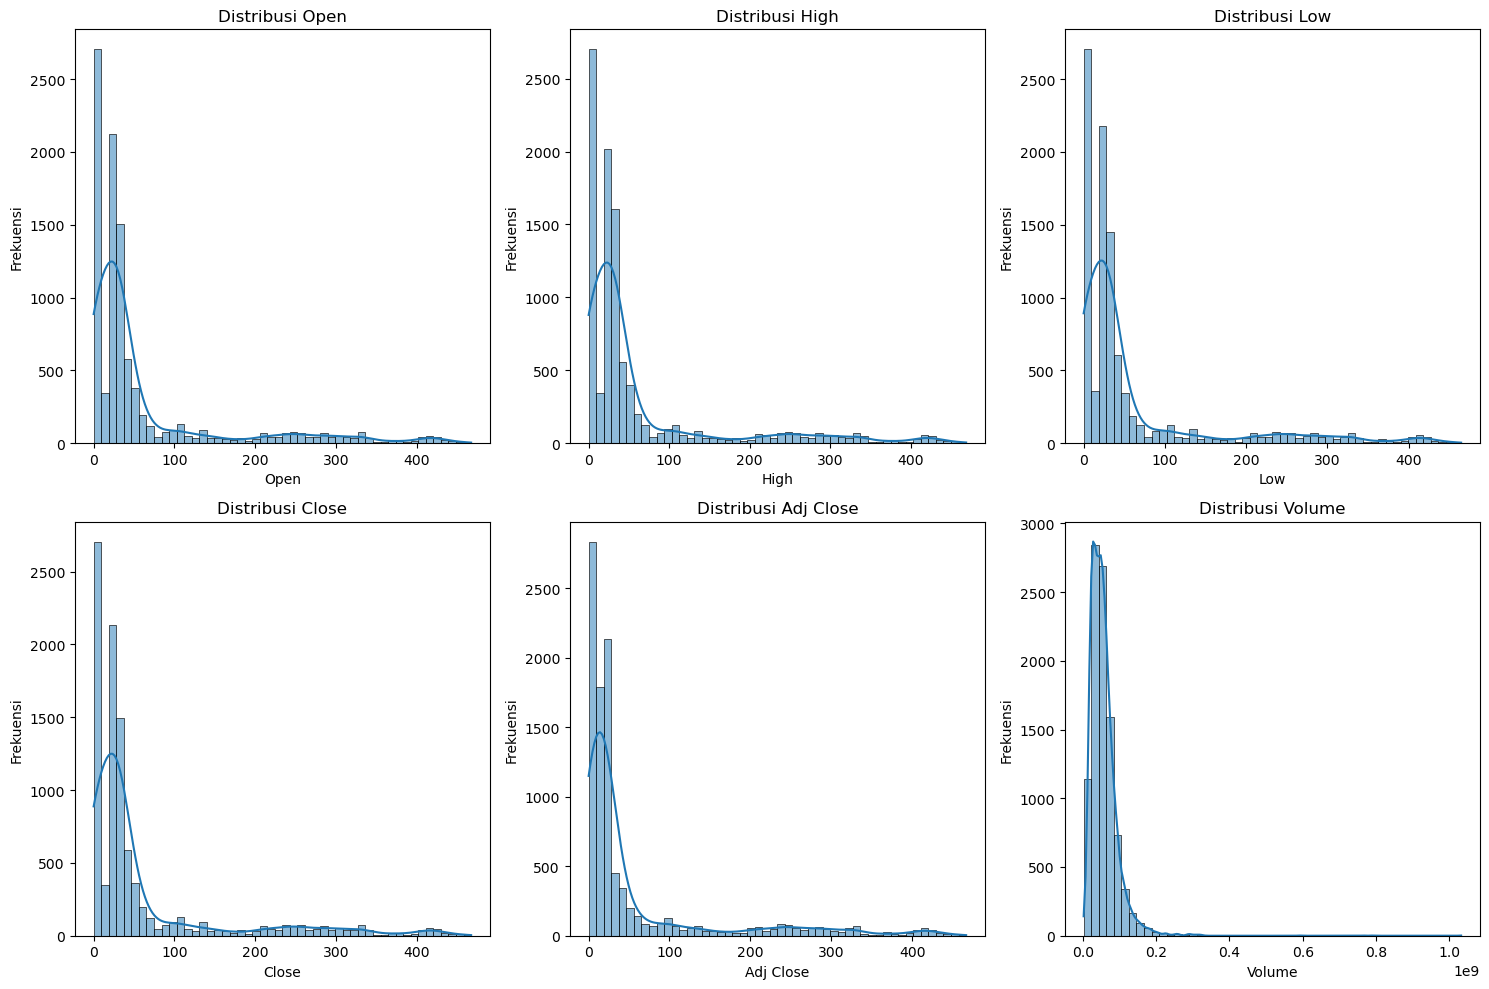

In [11]:
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

plt.figure(figsize=(15, 10))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f'Distribusi {col}')
    plt.xlabel(col)
    plt.ylabel('Frekuensi')

plt.tight_layout()
plt.show()

Pada tahapan ini tren dari harga sama penutupan `Close` akan dilihat, terlihat pada hasil visualisasi tren harga terkadang stagnan pada tahun 2000-an meningkat secara signifikan

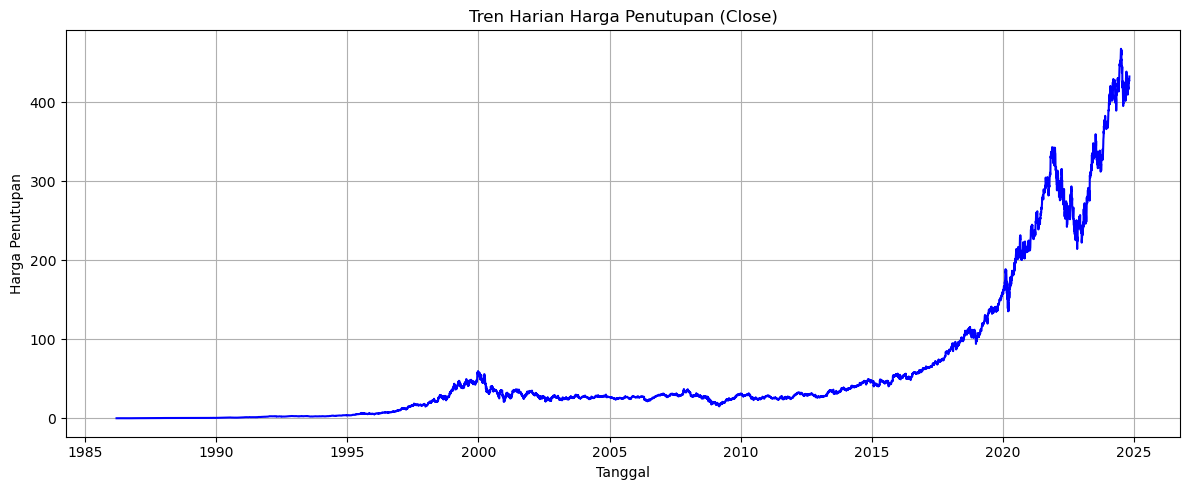

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Close'], color='blue')
plt.title('Tren Harian Harga Penutupan (Close)')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan')
plt.grid(True)
plt.tight_layout()
plt.show()

### 3.5 Multivariate Analysis

Pada tahapa ini kita akan memeriksa korelasi pada setiap fitur numerikal, terlihat fitur seperti `Open`, `High`, `Low`, `Close`, dan `Adj Close` yang kemungkinan terjadi overlapped.

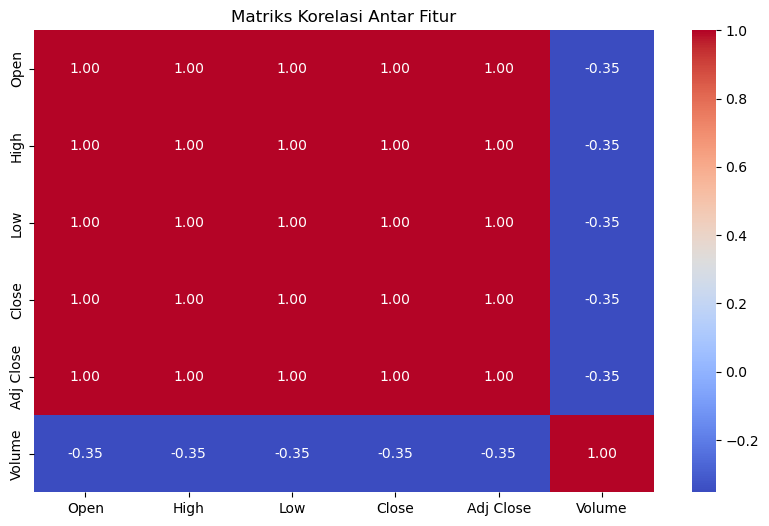

In [13]:
correlation_matrix = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriks Korelasi Antar Fitur')
plt.show()

Visualisasi diabwah untuk menampilkan korelasi antara `volume` dengan `close` menggunakan scatter plot.

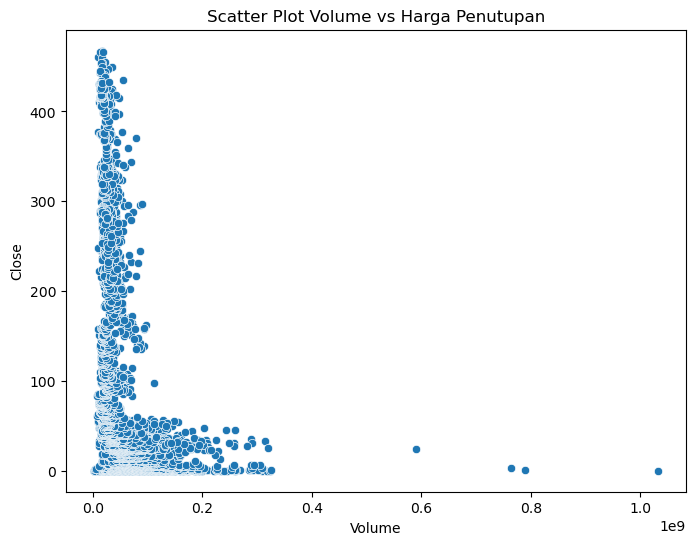

In [14]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Volume', y='Close', data=df)
plt.title('Scatter Plot Volume vs Harga Penutupan')
plt.xlabel('Volume')
plt.ylabel('Close')
plt.show()

Visualisasi berikut digunakan untuk melihat regresi linear antara `volume` dan dengan `close`, terlihat pada visualisasi korelasi sangat lemah

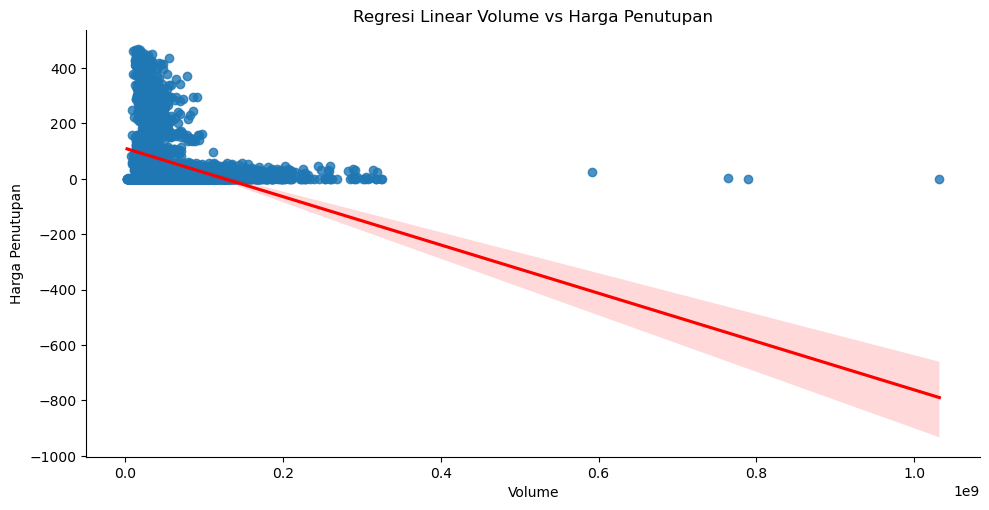

In [15]:
sns.lmplot(x='Volume', y='Close', data=df, aspect=2, height=5, line_kws={'color': 'red'})
plt.title('Regresi Linear Volume vs Harga Penutupan')
plt.xlabel('Volume')
plt.ylabel('Harga Penutupan')
plt.show()

## 4. Data Preparation

### 4.1 Penetapan Index Waktu

Data time series harus memiliki urutan waktu yang eksplisit, sehingga kolom `Date` dijadikan index untuk menjaga urutan data.

In [16]:
df_model = df[['Date', 'Close']]
df_model = df_model.set_index('Date')

### 4.2 Normalisasi Data

Pada tahapan ini akan dilakukan normalisasi agar dapat mempercepat proses pelatihan dan membantu model memahami pola dari data

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_model)

In [18]:
df_scaled

array([[1.48544396e-05],
       [2.22816594e-05],
       [2.59974050e-05],
       ...,
       [9.12357957e-01],
       [9.23823974e-01],
       [9.25064668e-01]])

### 4.3 Penentuan Sequence Data

Menentukan model model belajar memprediksi harga pada hari ke-61 berdasarkan 60 hari sebelumnya.

In [19]:
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(df_scaled, sequence_length)



### 4.4 Data Splitting

Data dibagi dengan rasio 80:20 untuk training dan testing agar model diuji pada data yang belum pernah dilihat sebelumnya.

In [20]:
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

## 5. Modelling

### Callbacks

Pada tahapan ini, fungsi callbacks `reduce_lr_callback` dibuat agar saat *training* learning rate pada model dapat disesuaikan secara otomatis saat model stagnan. Fungsi callback `early_stopping_callback` juga dibuat agar pelatihan dapat berhenti ketika evaluasi model tidak membaik, dengan begitu resource dapat lebih dihemat.

In [21]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    verbose=1,
    restore_best_weights=True
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

Pada tahapan awal, model `LSTM` dipilih untuk membangun analisis prediktif karena memang sesuai untuk analisa forecasting time series

### 5.1 LSTM Approach

#### 5.1.1 Development

Pada tahapan ini, model deep learning 3 lapis LSTM berurutan (64, 64, dan 32 unit) dibangun untuk menangkap pola jangka pendek dan panjang dalam data time series.  Model dikompilasi dengan optimizer Adam dan loss MSE untuk prediksi nilai.

In [22]:
model_lstm = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(units=64, return_sequences=True),
    LSTM(units=32),
    Dense(units=25),
    Dense(units=1)
]) 

model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │           825 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,187 (246.82 KB)

 Trainable params: 63,187 (246.82 KB)

 Non-trainable params: 0 (0.00 B)

Pada tahapan ini, model di latih menggunakan parameter-parameter yang sudah ditentukan, beserta fungsi callbacks yang sudah di buat sebelumnya

In [23]:
history_lstm = model_lstm.fit(X_train, y_train, 
                    epochs=20, 
                    batch_size=32, 
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping_callback, reduce_lr_callback],
                    verbose=1)

Epoch 1/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 1.9699e-04 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 2/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 1.0166e-05 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 3/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 8.5307e-06 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 4/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 9.9482e-06 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 5/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 6.7782e-06 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 6/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 7.4957e-06 - val_loss: 9.5586e-04 - learning_rate: 0.0010
Epoch 7/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 6.4787e-06 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 8/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 5.5875e-06 - val_loss: 8.0631e-04 - learning_rate: 0.0010
Epoch 9/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 4.9099e-06

#### 5.1.2 Evaluation

Pada tahapan ini, loss dari model akan di evaluasi terlebih dahulu.

In [24]:
test_loss = model_lstm.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1590e-04
Test Loss: 0.0005057079833932221


Evalusasi menggunakan berbagai metrik dilakukan untuk melihat performa dari model yang digunakan, pada hasil akhir terlihat evaluasi pada metrik R-Squared menunjukan hasil yang hampir sempurna.

In [25]:
lstm_prediction = model_lstm.predict(X_test)
lstm_prediction = scaler.inverse_transform(lstm_prediction)
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))

tanggal_prediksi = df_model.index[-len(y_test):]

comparison = pd.DataFrame({
    'Tanggal': tanggal_prediksi,
    'Harga Saham Asli': y_test_true.flatten(),
    'Harga Saham Prediksi': lstm_prediction.flatten()
})

mae = mean_absolute_error(y_test_true, lstm_prediction)
mse = mean_squared_error(y_test_true, lstm_prediction)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_true, lstm_prediction)

print(comparison.head())
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared Score: {r2:.4f}')

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
     Tanggal  Harga Saham Asli  Harga Saham Prediksi
0 2017-02-22         64.360001             64.953720
1 2017-02-23         64.620003             64.867523
2 2017-02-24         64.620003             64.814087
3 2017-02-27         64.230003             64.802170
4 2017-02-28         63.980000             64.735596
Mean Absolute Error (MAE): 6.9762
Mean Squared Error (MSE): 110.5113
Root Mean Squared Error (RMSE): 10.5124
R-squared Score: 0.9909


Tahapan evalusasi visual digunakan agar dapat membandingkan nilai saham asli dengan nilai saham prediksi secara jelas dan keseluruhan.

In [26]:
data = pd.DataFrame({
    'Tanggal': comparison['Tanggal'],
    'True Closing Price': comparison['Harga Saham Asli'],
    'Predicted Closing Price': comparison['Harga Saham Prediksi']
})

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data['Tanggal'],
    y=data['True Closing Price'],
    mode='lines',
    name='Harga Saham Asli',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=data['Tanggal'],
    y=data['Predicted Closing Price'],
    mode='lines',
    name='Harga Saham Prediksi',
    line=dict(color='red')
))

fig.update_layout(
    title="Prediksi Harga Saham vs Harga Asli",
    xaxis_title="Tanggal",
    yaxis_title="Harga Saham",
    template="plotly_dark",
    xaxis=dict(tickformat="%Y-%m-%d"),
    showlegend=True
)

fig.show()

### 5.2 GRU Approach

#### 5.2.1 Development

Pada tahapan ini, model deep learning satu lapis GRU dengan 50 unit untuk menangkap pola dalam data time,langsung diikuti oleh satu Dense layer dengan 1 unit untuk regresi. Model dikompilasi dengan optimizer Adam dan loss MSE untuk memprediksi nilai.

In [27]:
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model_gru.add(Dense(units=1))

model_gru.compile(optimizer='adam', loss='mean_squared_error')

model_gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50)             │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,001 (31.25 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

Pada tahapan ini, model di latih menggunakan parameter-parameter yang sudah ditentukan, beserta fungsi callbacks yang sudah di buat sebelumnya

In [28]:
history_gru = model_gru.fit(X_train, y_train, 
                    epochs=20, 
                    batch_size=32, 
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping_callback, reduce_lr_callback],
                    verbose=1)

Epoch 1/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 2.9077e-04 - val_loss: 1.3878e-04 - learning_rate: 0.0010
Epoch 2/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2.8718e-06 - val_loss: 1.2531e-04 - learning_rate: 0.0010
Epoch 3/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2.8402e-06 - val_loss: 1.2924e-04 - learning_rate: 0.0010
Epoch 4/20
239/242 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0373e-06
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 3.0346e-06 - val_loss: 1.2788e-04 - learning_rate: 0.0010
Epoch 5/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2.8476e-06 - val_loss: 1.3101e-04 - learning_rate: 5.0000e-04
Epoch 6/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2.3552e-06 - val_loss: 1.1609e-04 - learning_rate: 5.0000e-04
Epoch 7/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.2076e-06
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00025000001187

#### 5.2.2 Evaluation

Pada tahapan ini, loss dari model akan di evaluasi terlebih dahulu.

In [29]:
test_loss = model_gru.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5034e-05
Test Loss: 0.00010696613026084378


Evalusasi menggunakan berbagai metrik dilakukan untuk melihat performa dari model yang digunakan, pada hasil akhir terlihat evaluasi pada metrik R-Squared menunjukan hasil yang lebih baik daripada model LSTM waluapun hanya berbeda tipis.

In [30]:
gru_prediction = model_gru.predict(X_test)

gru_prediction = scaler.inverse_transform(gru_prediction)

y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))

print(f"Shape of predicted_stock_price: {gru_prediction.shape}")
print(f"Shape of y_test_true: {y_test_true.shape}")

tanggal_prediksi = df_model.index[-len(y_test):]

comparison = pd.DataFrame({
    'Tanggal': tanggal_prediksi,
    'Harga Saham Asli': y_test_true.flatten(),
    'Harga Saham Prediksi': gru_prediction.flatten()
})

mae = mean_absolute_error(y_test_true, gru_prediction)
mse = mean_squared_error(y_test_true, gru_prediction)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_true, gru_prediction)

print(comparison.head())
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared Score: {r2:.4f}')

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Shape of predicted_stock_price: (1936, 1)
Shape of y_test_true: (1936, 1)
     Tanggal  Harga Saham Asli  Harga Saham Prediksi
0 2017-02-22         64.360001             64.944969
1 2017-02-23         64.620003             64.879784
2 2017-02-24         64.620003             64.916809
3 2017-02-27         64.230003             64.954681
4 2017-02-28         63.980000             64.846367
Mean Absolute Error (MAE): 3.3612
Mean Squared Error (MSE): 23.3751
Root Mean Squared Error (RMSE): 4.8348
R-squared Score: 0.9981


Tahapan evalusasi visual digunakan agar dapat membandingkan nilai saham asli dengan nilai saham prediksi secara jelas dan keseluruhan.

In [31]:
data = pd.DataFrame({
    'Tanggal': comparison['Tanggal'],
    'True Closing Price': comparison['Harga Saham Asli'],
    'Predicted Closing Price': comparison['Harga Saham Prediksi']
})

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data['Tanggal'],
    y=data['True Closing Price'],
    mode='lines',
    name='Harga Saham Asli',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=data['Tanggal'],
    y=data['Predicted Closing Price'],
    mode='lines',
    name='Harga Saham Prediksi',
    line=dict(color='red')
))

fig.update_layout(
    title="Prediksi Harga Saham vs Harga Asli",
    xaxis_title="Tanggal",
    yaxis_title="Harga Saham",
    template="plotly_dark",
    xaxis=dict(tickformat="%Y-%m-%d"),
    showlegend=True
)

fig.show()

### 5.3 Comparing models

Pada tahapan ini, kedua model yaitu LSTM dan GRU akan dibandingkan secara visualisasi dengan harga saham aslinya

In [32]:
data_compare = pd.DataFrame({
    'Tanggal': tanggal_prediksi,
    'Harga Asli': y_test_true.flatten(),
    'Prediksi LSTM': lstm_prediction.flatten(),
    'Prediksi GRU': gru_prediction.flatten()
})

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data_compare['Tanggal'],
    y=data_compare['Harga Asli'],
    mode='lines',
    name='Harga Saham Asli',
    line=dict(color='blue', width=2)
))

fig.add_trace(go.Scatter(
    x=data_compare['Tanggal'],
    y=data_compare['Prediksi LSTM'],
    mode='lines',
    name='Prediksi LSTM',
    line=dict(color='red', width=2)
))

fig.add_trace(go.Scatter(
    x=data_compare['Tanggal'],
    y=data_compare['Prediksi GRU'],
    mode='lines',
    name='Prediksi GRU',
    line=dict(color='green', width=2)
))

fig.update_layout(
    title="Perbandingan Harga Saham Asli vs Prediksi (LSTM vs GRU)",
    xaxis_title="Tanggal",
    yaxis_title="Harga Saham",
    template="plotly_dark",
    xaxis=dict(tickformat="%Y-%m-%d"),
    showlegend=True
)

fig.show()


Terlihat pada visualisasi diatas, model GRU lebih akurat dalam memprediksi harga asli saham daripada model LSTM. Hal ini bisa disebabkan window sequence time yang diambil hanya jangka pendek saja, yaitu 60 hari. Sedangkan model LSTM lebih optimal jika digunakan pada jangka panjang. Selain itu bisa juga model LSTM memerlukan tuning agar outputnya lebih maksimal